# SMAI Assignment - 2

## Question 3: Face Recognition using Principal Component Analysis

This question requires you to create a basic facial recognition system using a technique called principal component analysis (PCA) 
by projecting the face images on the feature space (face space) which best
represents the variations among distinct faces. The face space is defined as the
“Eigenfaces", which are the eigenvectors of the set of faces.

The goal of implementing this system is to recognize a person's face by comparing it to a pre-existing database of faces, and identifying the closest match.

Link to paper on Eigenfaces: [https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf)

The AT&T face dataset contains a set of grayscale face images with dimensions 92x112. The images are organised in 40 directories (one for each subject), which have names of the form sX, where X indicates the subject number (between 1 and 40). In each of these directories, there are ten different images of that subject, which have names of the form Y.pgm, where Y is the image number for that subject (between 1 and 10). These 10 images per person are taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). <b>Link:</b> [https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)

#### Tasks
1. Load dataset and divide the date into training and test sets. 
2. Implement the PCA algorithm from scratch.
3. Implement image reconstruction using the eigen projections and visualise differences for different number of components.
4. Visualise the mean(Eigen face) generated.
5. Given training set, obtain accuracy by attempting a face regonition module and obtaining the accuracy for different number of principal components.

#### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from copy import copy
from tqdm import tqdm

#### Import Dataset
Assign labels for the images based on the subdirectories to obtain X(images array) and y (labels).

Ensure that the test data contains atleast one image from each category.

In [11]:
# iterate through all folders, load each image

trainAmt = 0.9
allFaces = []
labels = []

for i in range(1,41):
    for j in range(1,11):
        imgPath = os.path.join("ATnT", "s" + str(i), str(j) + ".pgm")
        img = cv2.imread(imgPath, -1)

        allFaces.append(img)
        labels.append(i)

# shuffle
randomOrder = np.random.permutation(len(labels))
allFaces = np.array(allFaces)[randomOrder]
labels = np.array(labels)[randomOrder]

# split
trainFaces = allFaces[:int(trainAmt*len(allFaces))]
trainLabels = labels[:int(trainAmt*len(allFaces))]

testFaces = allFaces[int(trainAmt*len(allFaces)): ]
testLabels = labels[int(trainAmt*len(allFaces)): ]

# 112x92 (= 10304) grayscale images,  360 in train, 40 in test
print(trainFaces.shape, trainLabels.shape)

(360, 112, 92) (360,)


#### Implement PCA Algorithm.

Explain your steps with comments and write a brief explanation of the method.

In [12]:
def principalComponentAnalysis(X, numComponents):
    """
    Implement pca in the following function by taking the following arguements:
    1. X(images array)
    2. number of components
    The function must return the eigen vectors (principal components) also termed "Eigen faces"
    """
    N = X.shape[0]
    # Center the data
    X = X.reshape(N,-1)
    mean_X = np.mean(X, axis=0)
    X_centered = X - mean_X
    
    covariance_matrix = X_centered @ X_centered.T / N

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Sort eigenvectors by eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    

    # Select the top 'numComponents' eigenvectors
    principal_components = (X_centered.T @ sorted_eigenvectors[:, :numComponents]).T
    norms = np.linalg.norm(principal_components, axis=1, ord=2, keepdims=True)
    normalized_principal_components = principal_components / norms
    
    return normalized_principal_components, mean_X

In [21]:
# plot the eigen faces
eigenfaces, meanface = principalComponentAnalysis(trainFaces, 150)

#### Implement Image Reconstruction from Eigenfaces


Explain your steps with comments and write a brief explanation of the method.

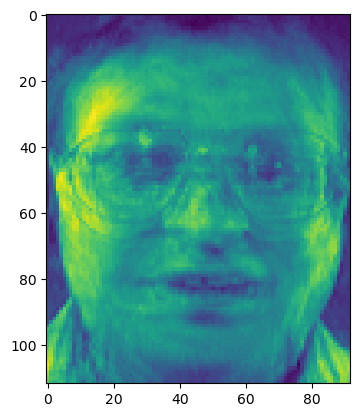

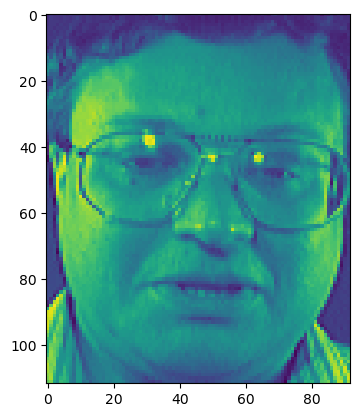

In [22]:
def imageReconstruction(testFace, eigenFaces, meanFace):
    """
    Helper function to reconstruct images
    """
    reconstructedFaces = []
    
    testFace = testFace.reshape(-1,112*92)
    
    for test in testFace:
        test_ = meanFace + np.dot(eigenFaces, test - meanFace) @ eigenFaces
        reconstructedFaces.append(test_)
    
    return np.array(reconstructedFaces)

reconstructedFaces = imageReconstruction(testFaces[1], eigenfaces, meanface)[0]
plt.imshow(reconstructedFaces.reshape(112,-1))
plt.show()
plt.imshow(testFaces[1])

#### Visualisation
Visualise the results for different number of factors(pc = 5, 10, 50, 100, etc.)

**Note:** Ensure that the images are labelled appropriately.

In [7]:
%matplotlib inline

def displayNfactors():

    # your code here

    return None

#### Implement face recognition module based on the norm
Explain your steps with comments and write a brief explanation of the method.

*   Test the module and report accuracies based on the number of components taken for a range of value and plot them. 
*   Also plot the mean square error vs the number of eigenvectors taken and report your observations. 
*   For further empirical analysis, plot the semi-log variant of the error plot obtained above.

In [23]:
def getClass(test_image, eigenFaces, meanFace, TrainingSet):
    """
    Arguments:
    1. Test image
    2. Eigenvectors
    3. Mean Eigen Face
    4. Training Set(X_train,y_train)

    The function must return the following:
    1. image with smallest error
    2. error value
    3. prediction class
    """
    reconstructedImage = imageReconstruction(test_image, eigenFaces, meanface)[0]
    
    training_images, training_labels = TrainingSet
    training_images = training_images.reshape(training_images.shape[0],-1)
    
    errors = np.mean((training_images - reconstructedImage)**2, axis = 1)
    
    closest_image_index = np.argmin(errors)
    
    closest_image = training_images[closest_image_index]
    
    predicted_class = training_labels[closest_image_index]
    
    
    return closest_image, errors[closest_image_index], predicted_class

Iterate through all the images in the test data and test the accuracy by taking different number of components

In [24]:
components = [3,5,10,20,30,40,50]
mse = []
accuracies = []
training_set = (trainFaces, trainLabels)
test_size = len(testLabels)

for numComponents in components:
    eigenfaces, meanface = principalComponentAnalysis(trainFaces, numComponents)
    acc = 0
    errors = 0
    for test_image, test_label in zip(testFaces, testLabels):
        closest_image, error, predicted_class = getClass(test_image, eigenfaces, meanface, training_set)
        acc += 1 if test_label == predicted_class else 0
        errors += error
    mse.append(errors / test_size)
    accuracies.append((100*acc) / test_size)    

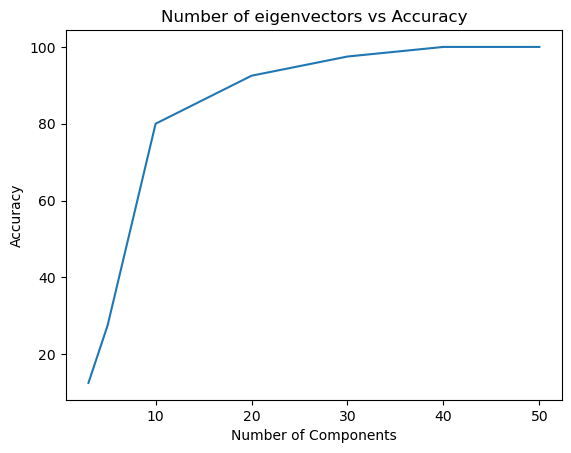

In [25]:
plt.plot(components, accuracies)
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('Number of eigenvectors vs Accuracy')
plt.show()

Plot Number of eigenvectors vs Mean Square Error

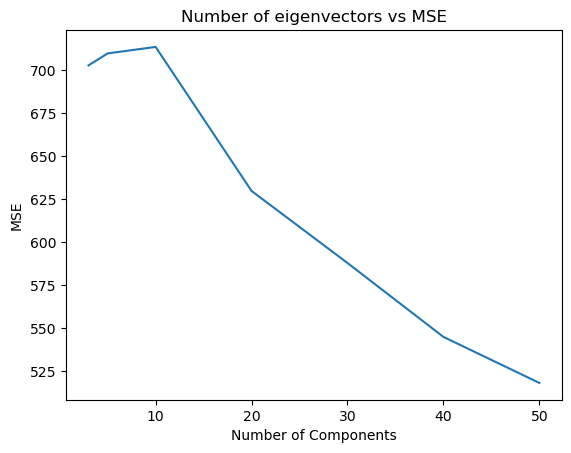

In [26]:
plt.plot(components, mse)
plt.xlabel('Number of Components')
plt.ylabel('MSE')
plt.title('Number of eigenvectors vs MSE')
plt.show()

Plot Number of eigenvectors vs Logarithmic Mean Square Error

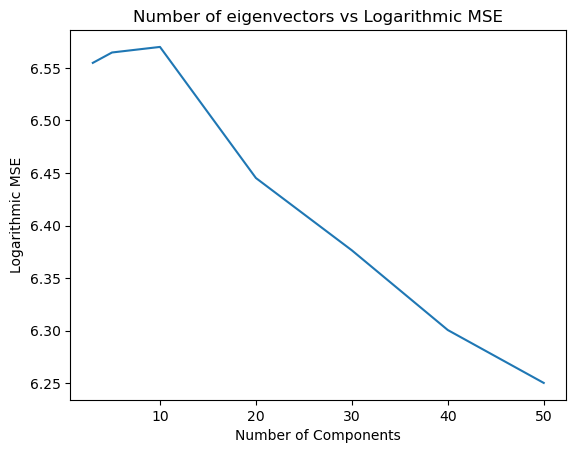

In [27]:
plt.plot(components, np.log(mse))
plt.xlabel('Number of Components')
plt.ylabel('Logarithmic MSE')
plt.title('Number of eigenvectors vs Logarithmic MSE')
plt.show()